In [1]:
import sys
sys.path.append("models/")

%load_ext autoreload
%autoreload 2
from collections import OrderedDict
import os
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pickle as pkl
import numpy as np

import itertools
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, GroupKFold
import statsmodels.api as sm


from dataloader import SurveyDataset, load_aggregate_travel_behavior, load_demo_v1
from M1_util_train_test import load_model, test
import linear_reg
import mnl
from setup import out_dir, data_dir, image_dir, model_dir, proj_dir


In [2]:
data_version = '1571'

model_type = 'AE'
sampling = 's'

zoomlevel = 'zoom15'

variable_names = ['active','auto','mas','pt', 'trpgen']

demo_variables = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']


# Load Model Embeddings

In [3]:
# 0.7
with open(proj_dir+"latent_space/2023-07-01T02-22-28_sae_kl_f32_ep69.pkl", "rb") as f:
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)
    sup_true_list = pkl.load(f)
    sup_list = pkl.load(f)

In [4]:
# Aggregate Embeddings
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
#     aggregate_embeddings.append(np.mean(sup_list[ct == i], axis=0))
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

x = aggregate_embeddings

x = x.reshape(x.shape[0],-1)

In [5]:
print(x.shape)

(1588, 4096)


# Load Trip Behavior

In [6]:
file = "MyDailyTravel/origin_trip_behavior.csv"
df_pivot = load_aggregate_travel_behavior(file, data_version)
y_ct = df_pivot['geoid'].to_list()
y = df_pivot[variable_names].to_numpy()[:,:4]

groups = df_pivot['train_test']
group_split = GroupKFold(n_splits=5)

In [7]:
if len(x) != len(y):
    x_mask = [True if c in y_ct else False for c in unique_ct]
    x = x[x_mask,:]
    unique_ct = list(np.array(unique_ct)[x_mask])
    y_mask = [True if c in unique_ct else False for c in y_ct]
    y = y[y_mask,:]
    y_ct = list(np.array(y_ct)[y_mask])

x = x[[y_ct.index(val) for val in unique_ct],:]
unique_ct = list(np.array(unique_ct)[np.array([y_ct.index(val) for val in unique_ct])])
for xc,yc in zip(unique_ct, y_ct):
    assert xc == yc

In [8]:
print(len(y))

1571


# 1. Linear Regression

### 1.1 Auto Share

In [42]:
y_index = 1

In [44]:
# Lasso
for a in (1e-3)*np.array([0.1,1,10,100,1000]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1876341104507446, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2545095682144165, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3698740005493164, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/

Parameter: 1.00e-04 	 Train score: 0.9962 	 Cross val score: 0.1830 	 Nonzero coef: 2691


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2509963512420654, tolerance: 0.006768209859728813
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.327174186706543, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2618064880371094, tolerance: 0.006768940482288599
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/s

Parameter: 1.00e-03 	 Train score: 0.8940 	 Cross val score: 0.5318 	 Nonzero coef: 790


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025388717651367188, tolerance: 0.006595651153475046
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023401260375976562, tolerance: 0.007110722362995148
  model = cd_fast.enet_coordinate_descent(


Parameter: 1.00e-02 	 Train score: 0.6735 	 Cross val score: 0.6399 	 Nonzero coef: 54
Parameter: 1.00e-01 	 Train score: 0.6056 	 Cross val score: 0.5943 	 Nonzero coef: 12
Parameter: 1.00e+00 	 Train score: 0.2215 	 Cross val score: 0.2168 	 Nonzero coef: 3


### 1.2 PT

In [38]:
y_index = 3

In [39]:
# Lasso
for a in (1e-3)*np.array([1,5,9,13,17]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19405460357666016, tolerance: 0.0011677747825160623
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3804285526275635, tolerance: 0.0011298793833702803
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4088153839111328, tolerance: 0.0012104269117116928
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python

Parameter: 1.00e-03 	 Train score: 0.7159 	 Cross val score: 0.4453 	 Nonzero coef: 371


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0026068687438964844, tolerance: 0.0012104269117116928
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01209259033203125, tolerance: 0.00128577696159482
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017757415771484375, tolerance: 0.0012813423527404666
  model = cd_fast.enet_coordinate_descent(


Parameter: 5.00e-03 	 Train score: 0.5382 	 Cross val score: 0.4826 	 Nonzero coef: 44
Parameter: 9.00e-03 	 Train score: 0.5204 	 Cross val score: 0.4834 	 Nonzero coef: 31
Parameter: 1.30e-02 	 Train score: 0.5095 	 Cross val score: 0.4818 	 Nonzero coef: 23
Parameter: 1.70e-02 	 Train score: 0.5030 	 Cross val score: 0.4804 	 Nonzero coef: 19


### 1.3 Active

In [40]:
y_index = 0

In [41]:
# Lasso
for a in (1e-3)*np.array([1,5,9,13,17]):
    lasso = linear_model.Lasso(alpha=a)
    cross_results = cross_validate(lasso, x, y[:,y_index], cv=group_split, groups=groups, scoring='r2', return_train_score=True, return_estimator=True)
    nz = 0
    for m in cross_results['estimator']:
        nz += sum(m.coef_ != 0)
    nz /= 5
    
    print("Parameter: %.2e \t Train score: %.4f \t Cross val score: %.4f \t Nonzero coef: %d" % 
          (a, cross_results['train_score'].mean(), cross_results['test_score'].mean(), nz))

/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4056975841522217, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0554556846618652, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6076326370239258, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.

Parameter: 1.00e-03 	 Train score: 0.8261 	 Cross val score: 0.4249 	 Nonzero coef: 629


/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1122751235961914, tolerance: 0.003382583614438772
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.052414894104003906, tolerance: 0.0032401869539171457
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08818721771240234, tolerance: 0.0033550586085766554
  model = cd_fast.enet_coordinate_descent(
/home/jtl/anaconda3/envs/qingyi/lib/pytho

Parameter: 5.00e-03 	 Train score: 0.5922 	 Cross val score: 0.5212 	 Nonzero coef: 80
Parameter: 9.00e-03 	 Train score: 0.5655 	 Cross val score: 0.5239 	 Nonzero coef: 40
Parameter: 1.30e-02 	 Train score: 0.5528 	 Cross val score: 0.5200 	 Nonzero coef: 32
Parameter: 1.70e-02 	 Train score: 0.5429 	 Cross val score: 0.5154 	 Nonzero coef: 26


# 2. MNL for Mode Share

In [ ]:
results = {}


In [64]:
from util_aggregate_models import mnl_torch

# dataloader and model definition

lr_list = [1e-5]
wd_list = [10000]


for i in range(5):
    
    train_filter = groups != i
    test_filter = groups == i
    x_train = x[train_filter]
    y_train = y[train_filter]
    x_test = x[test_filter]
    y_test = y[test_filter]
    sst_train = np.sum(np.power(y_train - np.mean(y_train, axis=0), 2), axis=0)
    sst_test = np.sum(np.power(y_test - np.mean(y_test, axis=0), 2), axis=0)
    
    trainset = SurveyDataset(torch.tensor(x_train,  dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
    trainloader = DataLoader(trainset, batch_size=len(trainset), shuffle=False)

    testset = SurveyDataset(torch.tensor(x_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.float))
    testloader = DataLoader(testset, batch_size=len(testset), shuffle=False)

    ret_dict = mnl_torch(trainloader, testloader, x_train.shape[-1], 
                         sst_train, sst_test, lr_list=lr_list, wd_list=wd_list,
                         save_models=True,
                         save_name='SAE+(4096)_0.7_'+str(i))
    
    results[i].update(ret_dict)
    

[lr: 1.00e-05, wd: 1.00e+04]
Early stopping at epoch 2510
[epoch: 2500] Train KL loss: 0.122 Train R2 score: 0.552 0.658 0.017 0.533 
[epoch: 2500] Test KL loss: 0.126 Test R2 score: 0.537 0.658 0.004 0.562 

[lr: 1.00e-05, wd: 1.00e+04]
Early stopping at epoch 2380
[epoch: 2370] Train KL loss: 0.118 Train R2 score: 0.579 0.673 0.042 0.545 
[epoch: 2370] Test KL loss: 0.142 Test R2 score: 0.457 0.606 -0.030 0.471 

[lr: 1.00e-05, wd: 1.00e+04]
Early stopping at epoch 1860
[epoch: 1850] Train KL loss: 0.120 Train R2 score: 0.574 0.683 0.031 0.551 
[epoch: 1850] Test KL loss: 0.124 Test R2 score: 0.459 0.619 -0.024 0.476 

[lr: 1.00e-05, wd: 1.00e+04]
Early stopping at epoch 1950
[epoch: 1940] Train KL loss: 0.123 Train R2 score: 0.553 0.661 0.023 0.542 
[epoch: 1940] Test KL loss: 0.116 Test R2 score: 0.629 0.681 0.001 0.501 

[lr: 1.00e-05, wd: 1.00e+04]
Early stopping at epoch 2160
[epoch: 2150] Train KL loss: 0.118 Train R2 score: 0.572 0.673 0.039 0.545 
[epoch: 2150] Test KL loss: 

In [65]:
df = []
lr_list = [0.00001]
wd_list = [0.1, 1, 10, 100, 1000, 10000, 100000]
for (lr, wd) in itertools.product(lr_list, wd_list):

    new = []
    
    for i in range(5):
        new2 = []
        for k,v in results[i][(lr,wd)].items():
            if k != 'train_loss' and k != 'test_loss':
                new2.append(results[i][(lr,wd)][k]) 
        new.append(new2)
        
    new = np.array(new) 
    
    df.append([lr] + [wd] + list(np.mean(new, axis=0)))

pd.DataFrame(np.array(df), columns = ['learning_rate','weight_decay','train_kl_loss','test_kl_loss','train_r2_auto','train_r2_active','train_r2_pt',
                                     'test_r2_auto','test_r2_active','test_r2_pt']).sort_values(by='test_kl_loss').round(5)


,learning_rate,weight_decay,train_kl_loss,test_kl_loss,train_r2_auto,train_r2_active,train_r2_pt,test_r2_auto,test_r2_active,test_r2_pt
5,0.00001,10000.0,0.12025,0.12949,0.66946,0.56594,0.54332,0.63736,0.51487,0.49577
6,0.00001,100000.0,0.12852,0.13254,0.63900,0.53046,0.50175,0.62035,0.50527,0.48919
4,0.00001,1000.0,0.10807,0.13404,0.71348,0.63340,0.61852,0.62020,0.50103,0.45060
3,0.00001,100.0,0.10394,0.13959,0.72915,0.66056,0.63124,0.59719,0.47439,0.39353
2,0.00001,10.0,0.09859,0.14144,0.74849,0.66269,0.70472,0.59081,0.46317,0.41114
1,0.00001,1.0,0.09893,0.14259,0.74703,0.67182,0.65979,0.58532,0.44627,0.39614
0,0.00001,0.1,0.09384,0.14289,0.76230,0.68272,0.67982,0.58735,0.46277,0.40504


(0.0, 0.2)

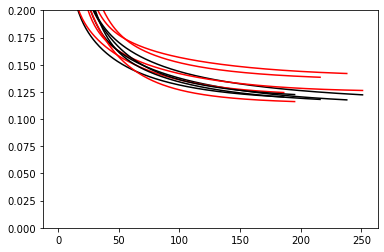

In [66]:
lr = 0.00001
wd = 10000
for i in range(5):
    plt.plot(results[i][(lr, wd)]['train_loss'], c='black')
    plt.plot(results[i][(lr, wd)]['test_loss'], c='red')
plt.ylim([0,0.2])